# Analyse des Séries Temporelles

Dans ce notebook, nous allons analyser en profondeur les caractéristiques temporelles des données de température de Paris.

Nous passerons des tendances visuelles globales aux tests statistiques spécifiques aux séries temporelles.

Notre objectif est de comprendre et analyser la série pour éclairer nos choix de modélisation. Ces analyses sont ainsi conçées pour caractériser la structure de nos données et incluront un examen détaillé de la tendance, de la saisonnalité, de l'autocorrélation et les résultats de tests statistiques fondamentaux, notamment ceux de la stationnarité.

## Plan du Notebook : 

1. Importation des bibliothèques et chargement des données.

2. Analyse Globale des séries temporelles.

3. Analyse Approfondie de la Saisonnalité.

4. Analyse de la Stationnarité.

5. Analyse d'Autocorrélation.

In [1]:
#Importation des bibliothèques

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from calendar import month_abbr
from calendar import day_abbr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Prépartaion des données

data_path = "data/hourly_data.csv"
df = pd.read_csv(data_path)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

temperature = df['temperature_2m']

print(f"Données chargées. Plage de temps : {temperature.index.min()} à {temperature.index.max()}")

display(temperature.head())

Données chargées. Plage de temps : 2000-01-01 00:00:00 à 2025-10-25 23:00:00


time
2000-01-01 00:00:00    6.0
2000-01-01 01:00:00    6.0
2000-01-01 02:00:00    5.9
2000-01-01 03:00:00    6.0
2000-01-01 04:00:00    6.1
Name: temperature_2m, dtype: float64

## 1. Analyse globale de la série temporelle

Nous commençons par tracer la série entière. Le graphique suivant représente l'évolution de la température à Paris sur une période de 25 ans, de 2000 à 2025 : 

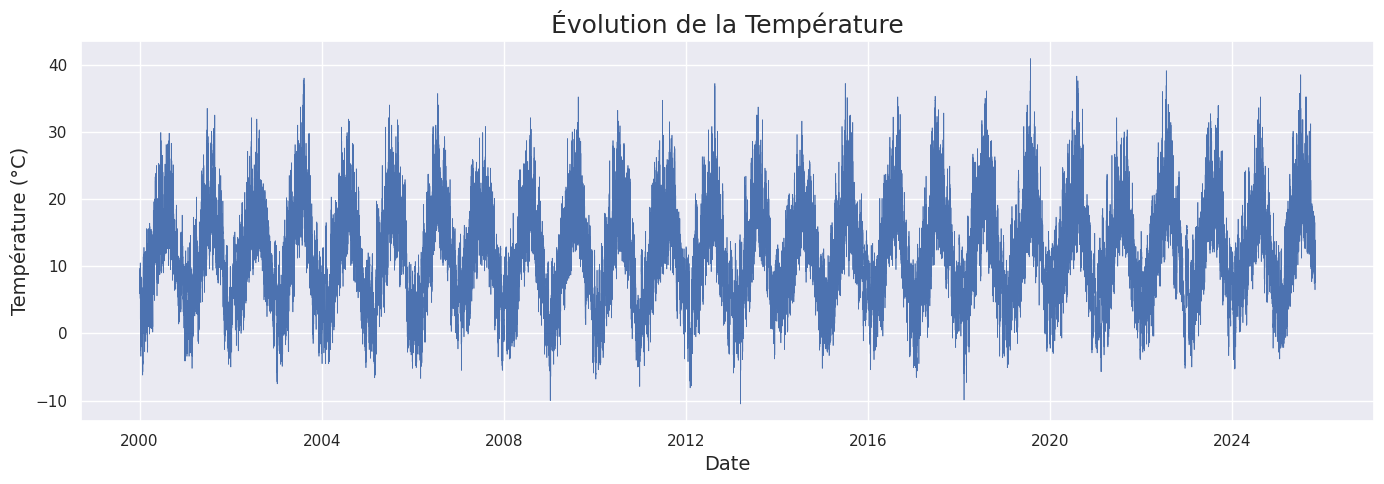

In [3]:
plt.figure(figsize=(14, 5))
sns.lineplot(
    data=temperature,
    palette="husl",           
    linewidth=0.5,                         
)

plt.title("Évolution de la Température", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Température (°C)", fontsize=14)

plt.tight_layout()
plt.show()

L'inspection visuelle révèle immédiatement une saisonnalité annuelle très prononcée et régulière, qui est la caractéristique dominante de cette série temporelle. Les températures suivent un cycle annuel systématique, avec des pics durant les mois d'été et des creux durant les mois d'hiver. Cette oscillation saisonnière est de forte amplitude et se répète avec une grande régularité sur l'ensemble des deux décennies.

En plus de ce cycle saisonnier, la série présente une forte volatilité à haute fréquence, visible par les "dents de scie" rapides de la courbe. Celles-ci représentent les fluctuations météorologiques quotidiennes, qui se superposent au schéma saisonnier de base. On note également la présence d'événements extrêmes, tels que des pics caniculaires et des vagues de froid, qui se manifestent par des dépassements notables de l'amplitude saisonnière moyenne.

Concernant la tendance à long terme (par exemple, un réchauffement ou un refroidissement sur 25 ans), elle n'est pas visuellement évidente à ce stade. Elle est potentiellement masquée par la forte variance saisonnière et la volatilité à court terme.

Ce premier graphique temporel confirme la nature cyclique et volatile des données. Une analyse plus détaillée et une décomposition formelle de la série en ses différentes composantes – tendance, saisonnalité et résidus – seront effectuées dans la suite de ce notebook pour quantifier ces observations.

## 2. Analyse des profils saisonniers

Le graphique suivant, de type "profil saisonnier", superpose les courbes de température moyenne mensuelle pour différentes années :

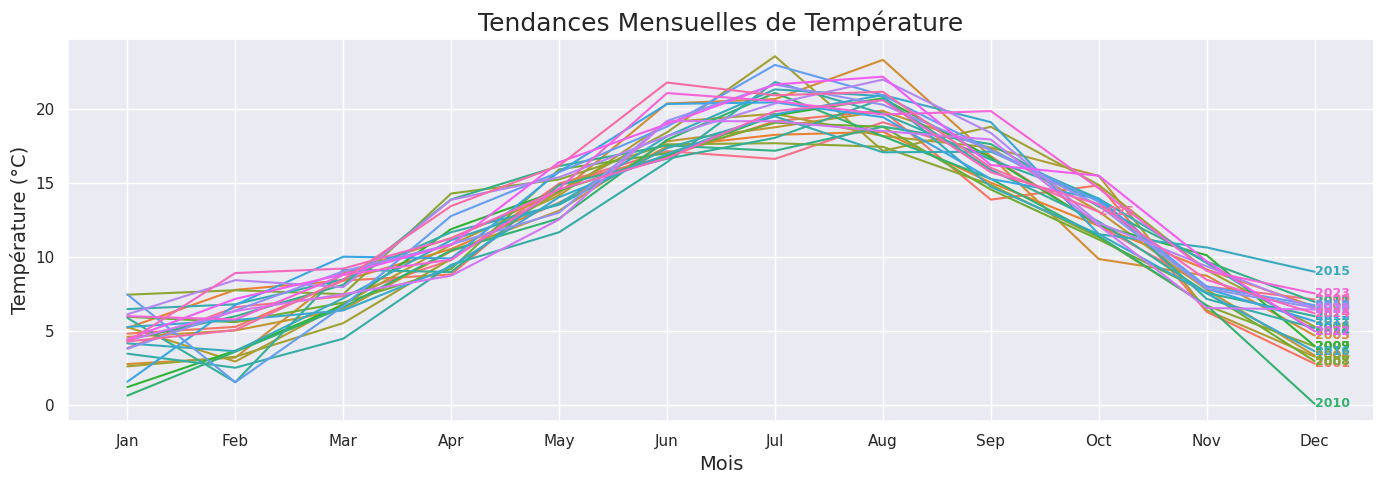

In [4]:
monthly_grouped = temperature.groupby(
    [temperature.index.year, temperature.index.month]
).mean()

monthly_grouped.index.names = ['year', 'month_num']

monthly = monthly_grouped.reset_index()

month_order = list(month_abbr)[1:]  # ['Jan', 'Feb', ..., 'Dec']
monthly['month_name'] = monthly['month_num'].apply(lambda x: month_order[x-1])
monthly['month_name'] = pd.Categorical(monthly['month_name'], categories=month_order, ordered=True)

monthly.rename(columns={'temperature_2m': 'temperature'}, inplace=True)

plt.figure(figsize=(14, 5))
palette = sns.color_palette("husl", n_colors=monthly['year'].nunique())

sns.lineplot(
    data=monthly,
    x='month_name', y='temperature', hue='year', # 'y' a été renommé
    palette=palette, linewidth=1.5
)

for i, (year, subset) in enumerate(monthly.groupby('year')):
    plt.text(
        x=subset['month_name'].iloc[-1],
        y=subset['temperature'].iloc[-1], # 'y' a été renommé
        s=str(year),
        color=palette[i],
        fontsize=9,
        fontweight='bold',
        va='center'
    )

plt.title("Tendances Mensuelles de Température", fontsize=18)
plt.xlabel("Mois", fontsize=14)
plt.ylabel("Température (°C)", fontsize=14)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

Ce graphique offre une vue plus détaillée de la saisonnalité observée précédemment. Il confirme de manière éclatante le cycle saisonnier annuel comme étant le moteur principal des températures. Toutes les années, sans exception, suivent le même schéma : une augmentation de la température du début d'année jusqu'à un pic estival (situé en juillet ou août), suivie d'une diminution jusqu'en décembre.

L'apport principal de ce visuel est de mettre en évidence la variabilité interannuelle. Si le profil saisonnier est constant, son intensité varie considérablement d'une année à l'autre. On observe un "faisceau" de courbes, montrant que :

    1. La variabilité des pics estivaux est forte : Certains étés sont notablement plus chauds (courbes du haut, dépassant 22°C en moyenne mensuelle), tandis que d'autres sont plus frais (courbes du bas, peinant à atteindre 17°C).

    2. La variabilité hivernale est également présente : Les mois de janvier et février montrent un écart de plusieurs degrés entre les hivers les plus froids (proches de 0°C) et les plus doux (autour de 7°C).

    3. Les mois de transition (printemps et automne) voient les courbes se croiser fréquemment, illustrant des différences dans la rapidité de l'installation ou de la fin des saisons.

En synthèse, ce graphique décompose la volatilité totale observée dans le premier graphique. Il sépare le schéma saisonnier commun de la variation interannuelle. Il sera donc crucial pour l'analyse de quantifier cette variance interannuelle et de comprendre si elle est purement aléatoire ou si elle est liée à d'autres facteurs ou cycles de plus long terme.

## 3. Évolution interannuelle par mois

Le graphique en panneaux suivant décompose l'analyse saisonnière en présentant douze mini-graphiques, un pour chaque mois de l'année. Chaque panneau individuel montre l'évolution de la température moyenne pour un mois spécifique.

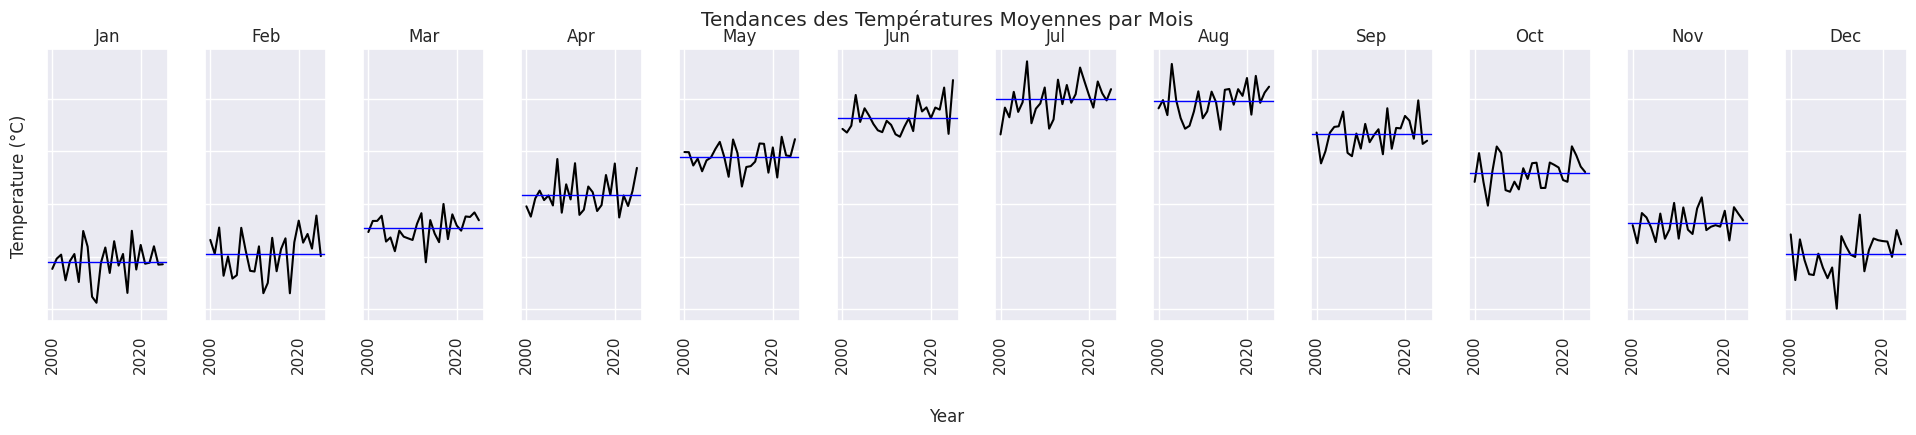

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=12, figsize=(24, 4), sharey=True)

for i, month in enumerate(month_order):
    month_data = monthly[monthly['month_name'] == month]
    if month_data.empty:
        axes[i].set_visible(False)
        continue

    mean_temp = month_data['temperature'].mean()

    # Plot temperature per year for this month
    axes[i].plot(month_data['year'], month_data['temperature'], color='black')
    # Plot average line
    axes[i].axhline(mean_temp, color='blue', linestyle='-', linewidth=1, label='Average')

    axes[i].set_title(month)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=90)

    if i == 0:
        axes[i].set_ylabel('Temperature (°C)')
    else:
        axes[i].set_yticklabels([])

fig.suptitle('Tendances des Températures Moyennes par Mois')
fig.text(0.5, -0.05, 'Year', ha='center')
fig.subplots_adjust(wspace=0.3, bottom=0.2)

plt.show()

L'objectif de cette visualisation était d'isoler la variabilité interannuelle et de rechercher une tendance de fond, en supprimant l'effet du cycle saisonnier principal.

L'observation la plus notable est l'absence d'une tendance linéaire claire et uniforme. Dans la plupart des panneaux, la température moyenne du mois oscille de manière significative autour de la moyenne à long terme sans montrer d'augmentation ou de diminution systématique.

Ce qui est mis en évidence est l'importante variabilité interannuelle. Pour n'importe quel mois donné (par exemple, juillet), certaines années sont nettement plus chaudes que la moyenne de juillet, tandis que d'autres sont nettement plus fraîches. Cette visualisation confirme que la "dispersion" observée dans le graphique précédent (le faisceau de courbes) n'est pas un bruit aléatoire uniforme, mais une fluctuation annuelle significative. Cela suggère la présence de cycles ou de variations de plus basse fréquence (pluriannuels) qui influencent les températures, en plus du cycle saisonnier annuel.

## 4. Identification du cycle diurne

Le graphique suivant superpose les profils de température de nombreuses journées individuelles où l'axe X représente le temps sur un cycle de 24 heures :

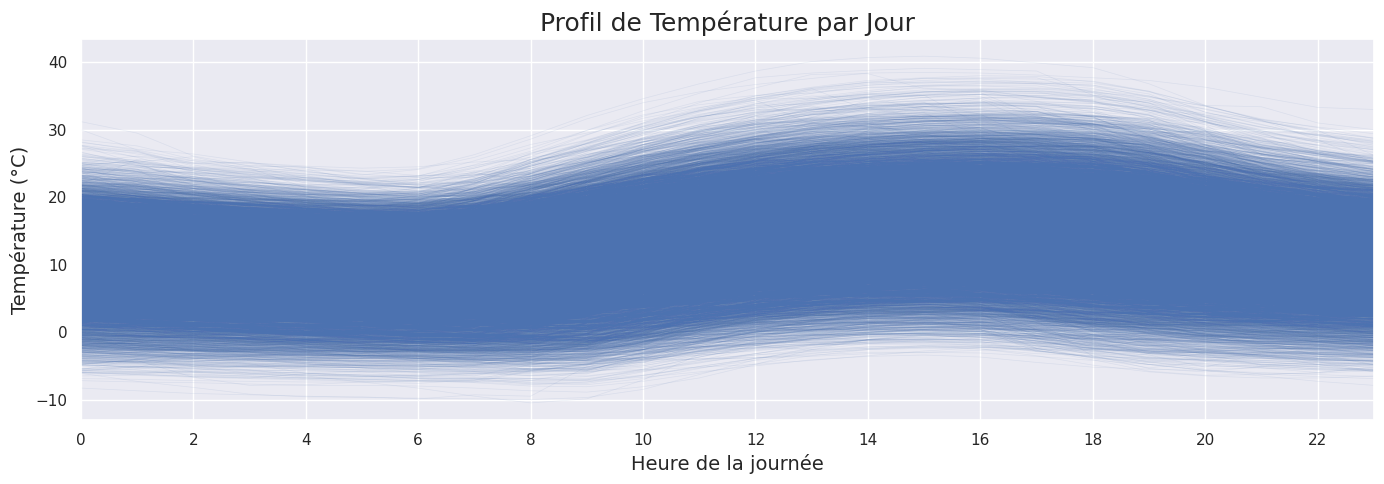

In [6]:
plt.figure(figsize=(14, 5))
sns.lineplot(
    x=temperature.index.hour,      
    y=temperature,                 
    units=temperature.index.date,  
    estimator=None,                
    palette="husl",
    legend=False,
    linewidth=0.5,
    alpha=0.1                      
)

plt.title("Profil de Température par Jour", fontsize=18)
plt.xlabel("Heure de la journée", fontsize=14)
plt.ylabel("Température (°C)", fontsize=14)

# Définir les graduations de l'axe X (de 0h à 23h)
plt.xticks(ticks=range(0, 25, 2)) # Une graduation toutes les 2 heures
plt.xlim(0, 23)

plt.tight_layout()
plt.show()

Cette visualisation met en évidence un second cycle fondamental : le cycle diurne (journalier), qui s'ajoute au cycle annuel déjà identifié. On observe un schéma très net et répété : les températures sont au plus bas tôt le matin (généralement autour de 06h) puis augmentent avec le lever du soleil pour atteindre un pic dans l'après-midi (typiquement entre 14h et 18h), avant de redescendre durant la nuit.

L'élément le plus frappant est l'extrême dispersion verticale des courbes, allant de -10°C à plus de 40°C. Cette dispersion n'est pas aléatoire ; elle est le résultat de la superposition du cycle saisonnier sur le cycle diurne. Les lignes du bas, parfois négatives, représentent les profils des jours d'hiver, tandis que les lignes du haut, dépassant 30°C ou 40°C, correspondent aux jours d'été. Le "cœur" très dense des courbes (en rose) représente la majorité des jours de mi-saison.

En conclusion, ce graphique est essentiel car il confirme que les données de température sont régies par deux cycles imbriqués : un cycle annuel (qui fixe le niveau de température moyen du jour) et un cycle diurne (qui module cette température au fil des heures). On note également que l'amplitude de ce cycle diurne semble elle-même varier en fonction de la saison : les jours d'été (lignes hautes) montrent une "vague" journalière plus ample que les jours d'hiver (lignes basses, qui sont comparativement plus plates).

## 5. Décomposition de la Série Temporelle

A cette d'analyse, il est essentiel de comprendre le concept de décomposition des séries temporelles. 

Une série temporelle, comme nos données de température, est souvent la somme de plusieurs influences sous-jacentes. La décomposition est une méthode statistique qui vise à séparer la série en ses composantes principales pour mieux la comprendre.

Ces composantes sont typiquement :

    La Tendance (Trend) : L'évolution à long terme de la série (par exemple, une augmentation ou une diminution générale sur plusieurs années).

    La Saisonnalité (Seasonality) : Des motifs ou cycles qui se répètent à une fréquence fixe (par exemple, un cycle annuel, hebdomadaire ou journalier).

    Les Résidus (Resid) : Le "bruit" aléatoire qui reste une fois que la tendance et la saisonnalité ont été retirées.

Ainsi, notre série s'écrit comme $Y(t) = T(t) + S(t) + R(t)$, avec $T(t)$ : La Tendance, $S(t)$ : La Saisonnalité et $R(t)$ : Le Résidu.

Pour la température à Paris, ce concept est crucial car nous avons deux saisonnalités imbriquées :

    Un cycle annuel fort (les saisons : étés chauds, hivers froids).

    Un cycle journalier secondaire (le cycle diurne : plus chaud l'après-midi, plus frais la nuit).

L'outil de décomposition $seasonal\_decompose$ de la bibliothèque $statsmodels$ va nous permettre de les isoler et de les quantifier. Nous allons maintenant l'appliquer pour analyser spécifiquement le cycle journalier en utilisant nos données horaires.

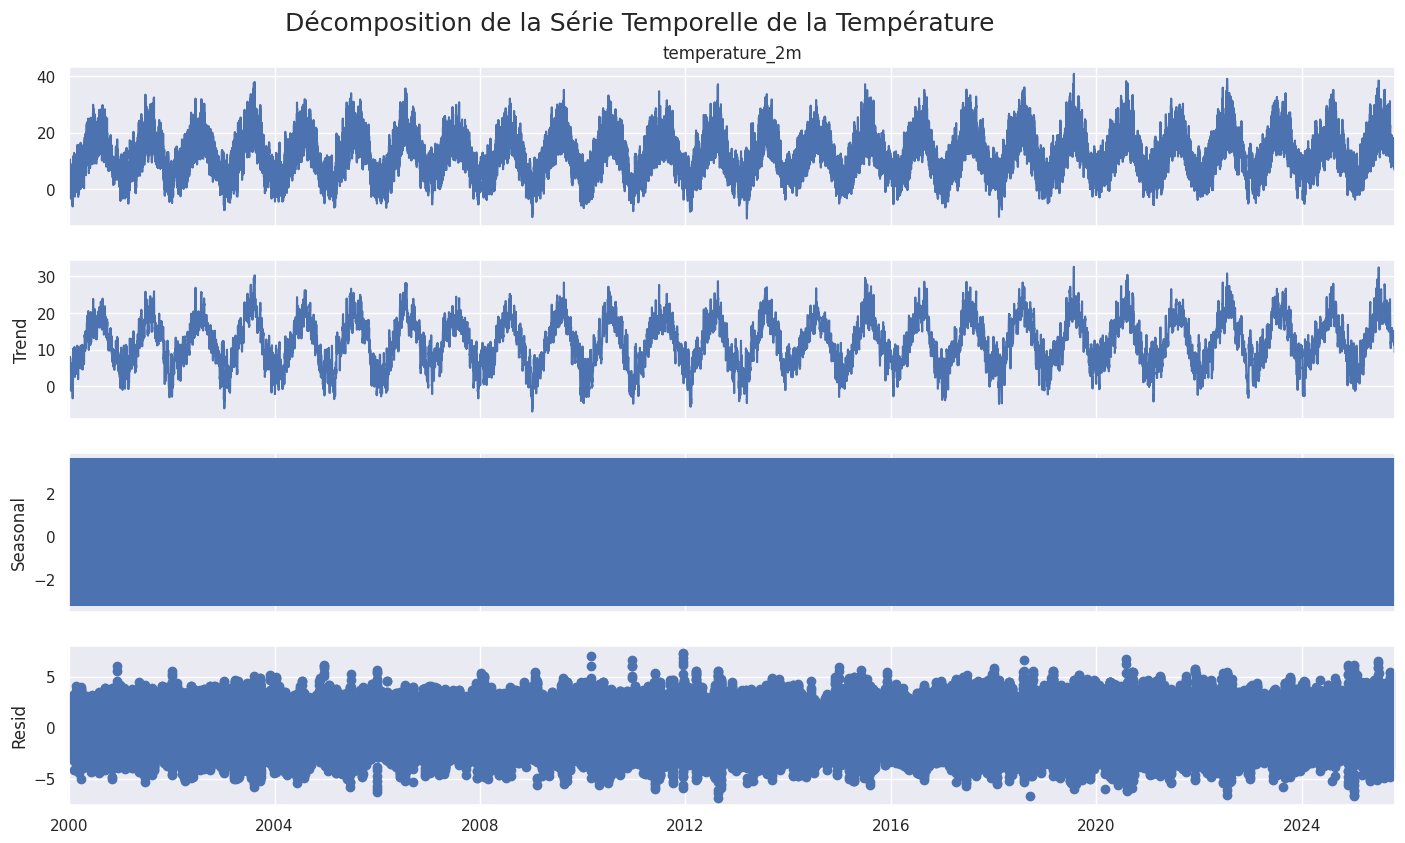

In [7]:
decomposition = seasonal_decompose(temperature, model='additive')

fig = decomposition.plot()
fig.set_size_inches(16, 9)

fig.suptitle('Décomposition de la Série Temporelle de la Température', fontsize=18)

plt.show()

Nous mènerons une analyse détaillée, en abordant successivement chacune des composantes : 

a) Composante Trend (Tendance)

    Observation : Le deuxième graphique, Trend, ne montre pas une ligne droite ou une simple courbe, mais affiche une oscillation sinusoïdale de grande amplitude et de basse fréquence.

    Interprétation : Étant donné que le filtre de statsmodels a été paramétré pour extraire la périodicité de 24 heures (la "saisonnalité" journalière), la composante Trend représente par définition toutes les variations de plus basse fréquence que le cycle journalier.

    Conclusion : Ce que nous observons dans ce panneau Trend est, en fait, la saisonnalité annuelle (cycle de 365 jours). Le modèle a "lissé" les variations quotidiennes, ne laissant que le cycle annuel dominant. Une inspection plus fine de cette tendance révèle également une très légère pente positive sur l'ensemble de la période, indice d'une tendance climatique à long terme (réchauffement).

b) Composante Seasonal (Saisonnalité)

    Observation : Le troisième graphique, Seasonal, apparaît comme un bloc solide et dense, centré sur zéro, avec une amplitude verticale constante.

    Interprétation : Cet artefact visuel est dû à la compression extrême de l'axe temporel. L'axe des ordonnées (Y) indique que l'amplitude de ce cycle journalier moyen se situe approximativement entre -3.5°C et +3.5°C.

    Conclusion : Le graphe apparaît comme un "bloc" dense et illisible, comme prévu. Son amplitude (d'environ -3.5 à +3.5) suggère une variation journalière moyenne d'environ 7°C. Ainsi, le "bloc" Seasonal n'est pas tout à fait interprétable. Nous devons "zoomer" dessus pour voir à quoi ressemble ce cycle journalier moyen.

c) Composante Resid (Résidu)

    Observation : Le dernier graphique, Resid, montre une série de points apparemment aléatoires, centrés sur zéro, sans structure périodique évidente.

    Interprétation : Cet ensemble de résidus s'apparente à un bruit blanc (white noise). Il n'y a pas de motifs clairs ou d'autocorrélation visible à cette échelle. L'amplitude des résidus (approximativement de -5°C à +5°C) quantifie l'erreur ou la variabilité que le modèle additif simple Tendance + Saisonnalité ne peut pas expliquer.

    Conclusion : L'aspect aléatoire et homoscédastique (variance constante) des résidus est un résultat positif. Il indique que le modèle additif a réussi à capturer les deux principales structures périodiques (annuelle et journalière) des données. Il n'y a pas de "fuite" de saisonnalité dans les résidus, ce qui valide l'adéquation du modèle pour cette étape d'analyse.

Pour résumer, la décomposition a réussi à séparer les données en ses composantes structurelles. Elle révèle que la série est dominée par une structure de saisonnalité imbriquée :

    Une saisonnalité annuelle de forte amplitude (capturée dans la composante Trend).

    Une saisonnalité diurne (journalière) d'amplitude secondaire (capturée dans la composante Seasonal).

Les résidus ne montrant aucune structure évidente, nous pouvons conclure que l'essentiel de la variance est expliqué par ces deux cycles.

Comme on l'a dit ci-dessus, le bloc de la saisonnalité n'est pas vraiment interprétable. Nous allons alors "zoomer" dessus pour voir à quoi ressemble ce cycle journalier moyen. Cela devrait nous révéler la forme cachée dans le bloc. Nous nous attendons à voir une vague classique : un creux pendant la nuit (probablement vers 5-6h du matin) et un pic dans l'après-midi (vers 15-16h).

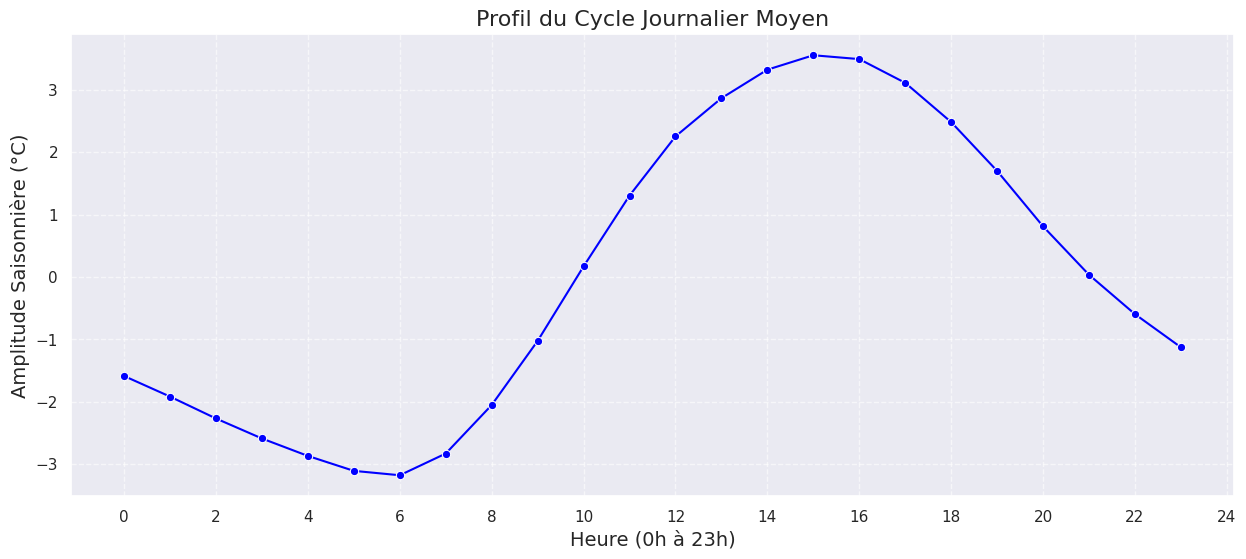

In [8]:
seasonal_component = decomposition.seasonal

#Extraction du motif unique de 24h 
daily_pattern = seasonal_component.iloc[0 : 24]

plt.figure(figsize=(15, 6))
sns.lineplot(data=daily_pattern.values, color='blue', marker='o') 

plt.title("Profil du Cycle Journalier Moyen", fontsize=16)
plt.xlabel("Heure (0h à 23h)", fontsize=14)
plt.ylabel("Amplitude Saisonnière (°C)", fontsize=14)
plt.xticks(ticks=range(0, 25, 2)) # Un repère toutes les 2 heures
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Le graphique montre exactement le profil attendu :

    Minimum : Atteint vers 5-6h du matin.

    Maximum : Atteint vers 15h (3 PM).

    Amplitude : L'écart entre le min (~-3.2°C) et le max (~+3.4°C) est bien d'environ 6.6°C, ce qui correspond à notre estimation de 7°C.


Mais une nouvelle question semble être pertinente à ce niveau : Ce profil étant un cycle moyen, mais est ce qu'il réaliste ? Est-ce que le cycle journalier est vraiment le même en Janvier (journées courtes et froides) qu'en Juillet (journées longues et chaudes) ?

Notre intuition dit que non.

Nous allons alors abandonner $seasonal\_decompose$, qui suppose une saisonnalité fixe. Pour tester notre nouvelle hypothèse (l'interaction mois/heure), nous devons utiliser un autre outil. 

Une heatmap semble idéale : En effet,  si notre hypothèse est correcte, nous ne verrons pas des colonnes de couleur uniforme. Nous devrions voir :

    Une zone "chaude" (rouge) concentrée en été (Juin-Août) et l'après-midi (14h-17h).

    Une zone "froide" (bleue) concentrée en hiver (Déc-Fév) et la nuit/matin.

    Surtout, l'amplitude (la différence de couleur au sein d'une même ligne) devrait être faible en hiver et très forte en été.

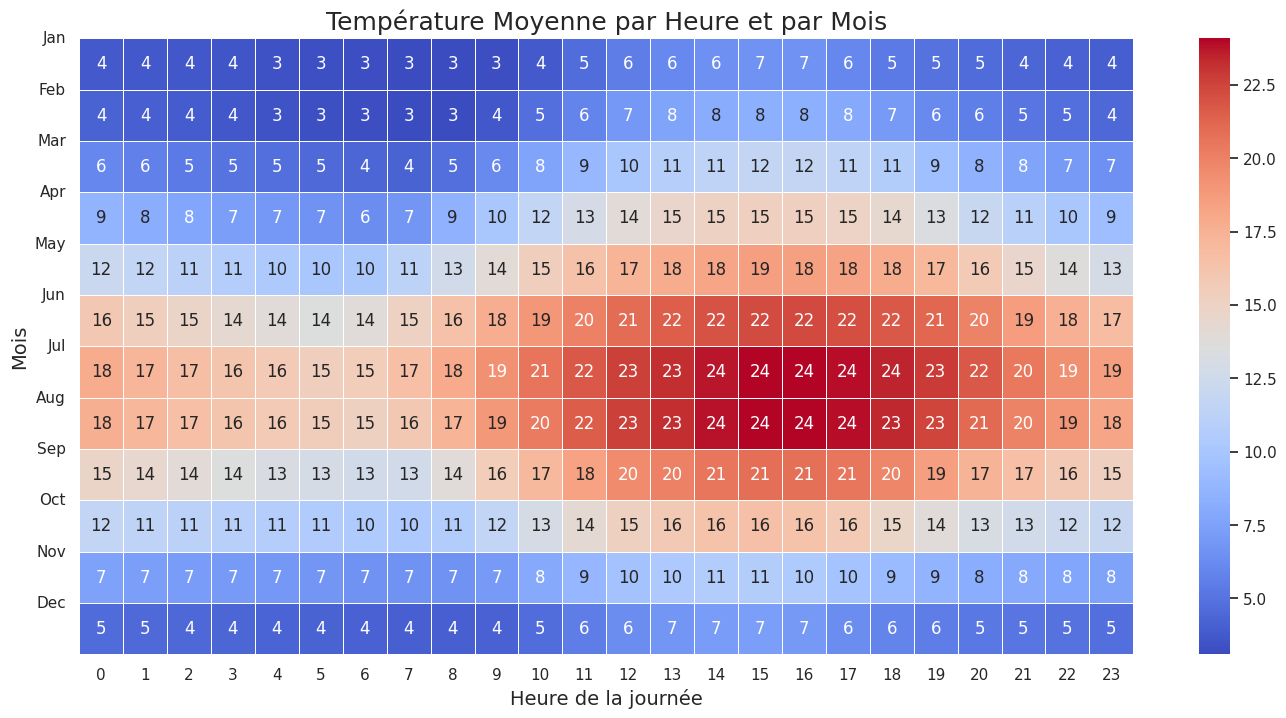

In [9]:
# 1. Grouper par mois et par heure
grouped = temperature.groupby(
    [temperature.index.month, temperature.index.hour]
).mean()

pivot_table = grouped.unstack()

# 3. Traçage de la Heatmap
plt.figure(figsize=(17, 8))
sns.heatmap(
    pivot_table, 
    cmap='coolwarm',
    annot=True,       
    fmt=".0f",       
    linewidths=.5     
)

# Obtenir les noms des mois en français
month_names = list(calendar.month_abbr)[1:]

plt.title('Température Moyenne par Heure et par Mois', fontsize=18)
plt.xlabel('Heure de la journée', fontsize=14)
plt.ylabel('Mois', fontsize=14)
plt.yticks(ticks=range(0, 12), labels=month_names, rotation=0)
plt.show()

L'analyse de cette heatmap est la plus riche de toutes et confirme notre hypothèse : Le profil journalier n'est PAS fixe. Il dépend massivement du mois.

    Amplitude en Hiver : La température ne varie que de 3°C à 5°C. L'amplitude journalière est minuscule.

    Amplitude en Été : La température varie de 14°C le matin à 24°C l'après-midi. L'amplitude est énorme (~10°C).

    Double Cycle : Ce graphique montre magnifiquement les deux cycles en même temps :

        Cycle Annuel (vertical) : Lisez n'importe quelle colonne (ex: 12h) de haut en bas : Bleu -> Rouge -> Bleu.

        Cycle Journalier (horizontal) : Lisez n'importe quelle ligne d'été (ex: Juil) de gauche à droite : Froid -> Chaud -> Froid.

Ainsi, la réalité est plus complexe qu'un simple modèle additif. Un bon modèle de prévision devra être capable de comprendre cette interaction entre les deux cycles.